<a href="https://colab.research.google.com/github/tamerhamad03/Pump-Analysis/blob/main/Pump_Analysis_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# -----------------------------
# Benötigte Bibliotheken laden
# -----------------------------
import pandas as pd                 # Für Tabellen und CSV-Verarbeitung
import numpy as np                  # Für numerische Berechnungen
import matplotlib.pyplot as plt     # Für Plots
import matplotlib.dates as mdates   # Für Zeitachsen-Formatierung

from google.colab import files
uploaded = files.upload()

df = pd.read_csv('volume_flow_data.csv')
df.head()

Saving volume_flow_data.csv to volume_flow_data (1).csv


,Timestamp,Volume Flow (m^3/h)
0,2024-04-01 00:00:00,312.54
1,2024-04-01 00:01:00,193.78
2,2024-04-01 00:02:00,393.96
3,2024-04-01 00:03:00,364.70
4,2024-04-01 00:04:00,100.33


**Task 1: Calculate the energy consumption**

In [41]:
rho = 969
g = 9.81
dt = 60
eta = 0.831

df = pd.read_csv('volume_flow_data.csv', index_col=False)   # CSV-Datei einlesen, alle Spalten normal als Daten übernehmen (keine Indexspalte setzen)
df.columns = ['timestamp','volume_flow_m^3/h']              # Spalten in "timestamp" und "volume_flow_m^3/h" umbenennen
df['volume_flow_m^3/s'] = df['volume_flow_m^3/h']/ 3600     # Umrechnung des Volumenstroms von m³/h in m³/s

flow_values = [110, 240, 300, 350, 400, 500, 540, 555]      # Referenz-Volumenströme in m³/h
height_values = [23, 22, 21, 20, 19, 16, 14.5, 14.3]        # zugehörige Förderhöhen in m

df['height_m'] =np.interp(df['volume_flow_m^3/h'], flow_values, height_values)      # Förderhöhe für jeden Messpunkt anhand Volumenstrom interpolieren

df['P_hyd'] = rho * g * df['volume_flow_m^3/s'] * df['height_m']      # Berechnung der Hydraulischen Leistung in kW
df['P_el'] = df['P_hyd'] / eta                                        # Berechnung der Elektrischen Leistung mithilfe des festen Wirkungsgrad "eta" aus dem Datenblatt
df['E_el'] = df['P_el'] * dt                                          # Berechnung der gesamten zugeführten Energie in kWs
total_energy_consumption = df['E_el'].sum() / 3.6e6                   # Umrechnung der gesamten zugeführten Energie in kWh
print(f"Total energy consumption: {total_energy_consumption} kWh")    # Ausgeben des Wertes für die gesamte zugeführte Energie in kWh



Total energy consumption: 406.217798834317 kWh


**Task 2: Average pump efficiency**

In [42]:
flow_values = [110, 200, 300, 350, 400, 500, 555]           # Referenz-Volumenströme in m³/h
eta_values = [0.45, 0.65, 0.79, 0.83, 0.85, 0.85, 0.81]     # zugehörige Wirkungsgrade

df['efficiency'] = np.interp(df['volume_flow_m^3/h'], flow_values, eta_values)    # Wirkungsgrade für jeden Messpunkt anhand Volumenstrom interpolieren
average_eta = df['efficiency'].mean()                                             # Berechnung des durchschnittlichen Mittelwertes
print(f"Durchschnittlicher Pumpenwirkungsgrad (aus Kennlinie interpoliert):{average_eta:.3f} oder {average_eta*100:.2f} %")     # Ausgeben des Wertes für den durchschnittlichen Pumpenwirkungsgrad


Durchschnittlicher Pumpenwirkungsgrad (aus Kennlinie interpoliert):0.699 oder 69.94 %


**Task 3: Calculate the unused energy**

In [52]:
df['P_hyd'] = df['P_el'] * average_eta                                    # Berechnung der hydraulischen Leistung mit dem aus der Kennlinie interpolierten durchschnittlichen Wirkungsgrad in kW
df['E_hyd'] = df['P_hyd'] * dt                                            # Berechnung der hydraulischen Energie in kWs
total_hydraulic_energy = df['E_hyd'].sum() / 3.6e6                        # Umrechnung der hydraulischen Energie in kWh
print(f"Total total hydraulic energy: {total_hydraulic_energy} kWh")      # Ausgeben des Wertes der hydraulischen Energie in kWh

unused_energy_kWh = total_energy_consumption - total_hydraulic_energy     # Berechnung der ungenutzten Energie
print(f"Nicht genutzte Energie (Verluste): {unused_energy_kWh:.2f} kWh")  # Ausgeben des Wertes de ungenutzten Energie

Total total hydraulic energy: 284.1238144182255 kWh
Nicht genutzte Energie (Verluste): 122.09 kWh


**Task 4: Add additional analysis**

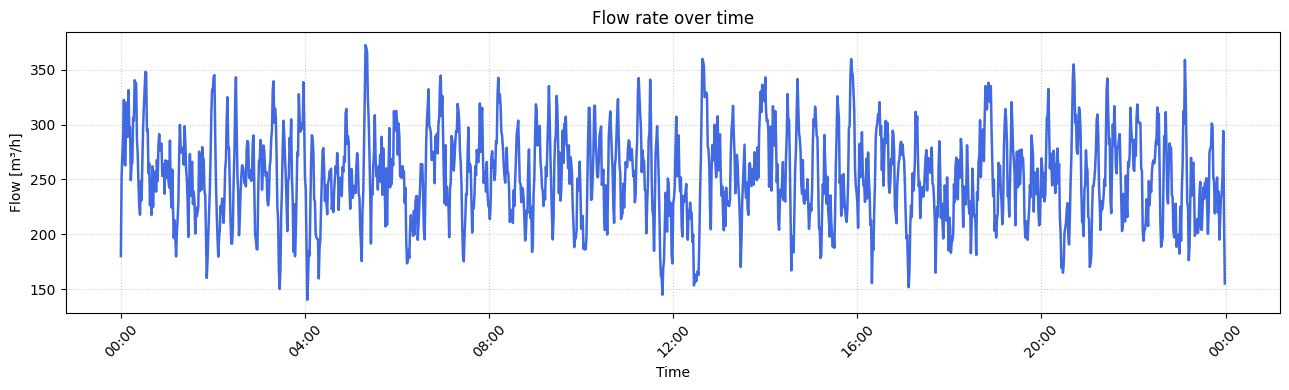

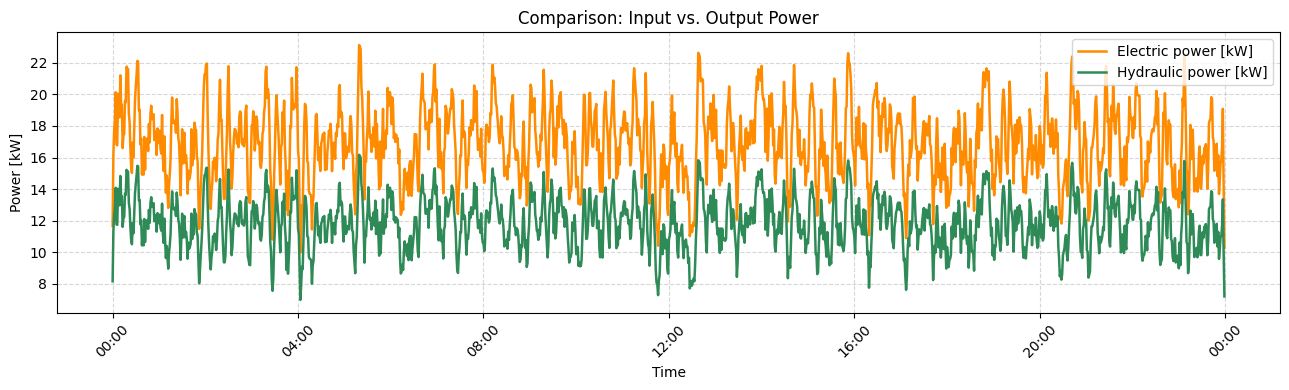

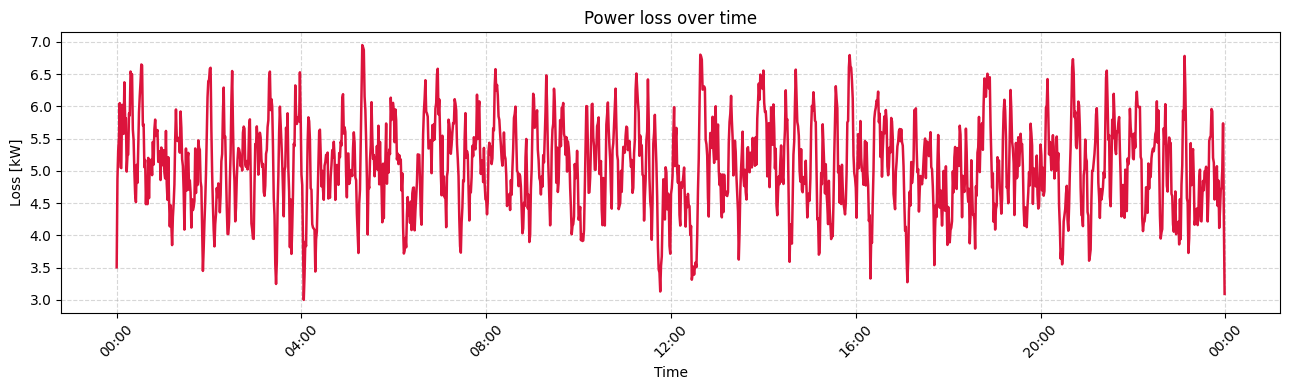

In [54]:
# Sicherstellen, dass die Zeitspalte richtig interpretiert wird
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Gleitender Mittelwert (Fenster = 5)
def moving_average(values, window=5):
    weights = np.ones(window) / window
    return np.convolve(values, weights, mode='same')

# Leistungen in kW berechnen
df['P_el_kW'] = df['P_el'] / 1000
df['P_hyd_kW'] = df['P_hyd'] / 1000
df['P_loss_kW'] = df['P_el_kW'] - df['P_hyd_kW']

# Werte glätten
df['Q_smooth'] = moving_average(df['volume_flow_m^3/h'], 5)
df['el_smooth'] = moving_average(df['P_el_kW'], 5)
df['hyd_smooth'] = moving_average(df['P_hyd_kW'], 5)
df['loss_smooth'] = moving_average(df['P_loss_kW'], 5)

# --- Funktion für 4-Stunden-Takt auf X-Achse ---
def format_x_axis(ax):
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=4))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.xticks(rotation=45)

# -------------------------------
# Plot 1: Volumenstrom über Zeit
# -------------------------------
fig, ax1 = plt.subplots(figsize=(13, 4))
ax1.plot(df['timestamp'], df['Q_smooth'], color='royalblue', lw=1.8)
ax1.set_title('Flow rate over time')
ax1.set_xlabel('Time')
ax1.set_ylabel('Flow [m³/h]')
ax1.grid(True, linestyle=':', alpha=0.6)
format_x_axis(ax1)
plt.tight_layout()
plt.show()

# ------------------------------------------
# Plot 2: Hydraulische vs. elektrische Power
# ------------------------------------------
fig, ax2 = plt.subplots(figsize=(13, 4))
ax2.plot(df['timestamp'], df['el_smooth'], label='Electric power [kW]', color='darkorange', lw=1.8)
ax2.plot(df['timestamp'], df['hyd_smooth'], label='Hydraulic power [kW]', color='seagreen', lw=1.8)
ax2.set_title('Comparison: Input vs. Output Power')
ax2.set_xlabel('Time')
ax2.set_ylabel('Power [kW]')
ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.5)
format_x_axis(ax2)
plt.tight_layout()
plt.show()

# -------------------------------
# Plot 3: Leistungsverlust über Zeit
# -------------------------------
fig, ax3 = plt.subplots(figsize=(13, 4))
ax3.plot(df['timestamp'], df['loss_smooth'], color='crimson', lw=1.8)
ax3.set_title('Power loss over time')
ax3.set_xlabel('Time')
ax3.set_ylabel('Loss [kW]')
ax3.grid(True, linestyle='--', alpha=0.5)
format_x_axis(ax3)
plt.tight_layout()
plt.show()

